In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 이미지에 들어가는 한글을 제대로 보기 위해 한글 폰트 적용
import platform
font_dict = {
    'Linux': 'Noto Sans CJK KR',
    'Darwin': 'Apple SD Gothic Neo', # macOS
    'Windows': 'Malgun Gothic' # MS-Windows
}
try:
    mpl.rc('font', family=font_dict[platform.system()])
except:
    pass
mpl.rc('axes', unicode_minus=False) # mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline

In [2]:
from pathlib import Path

data= Path('../data')

#라이브러리 불러오기

#입력 데이터 설정

In [3]:
# 위의 라벨링 데이터와는 별개의 mode 설정

condition = 2
#usecols=['대여소_구', '대여소ID'
if (condition==1):
    input_data = pd.read_csv(data / 'BABCdata_condition_1.zip', compression='zip',
                            usecols = ['TE_r','n3','k3','d3','n2','k2','d2'])
elif (condition==2):
    input_data = pd.read_csv(data / 'BABCdata_edit_condition_2.zip', compression='zip',
                            usecols = ['TE_r','n3','k3','d3','n2','k2','d2'])
elif (condition==3):
    input_data = pd.read_csv(data / 'BABCdata_condition_3.zip', compression='zip',
                            usecols = ['TE_r','n3','k3','d3','n2','k2','d2'])
else:
    print("올바른 condition이 아닙니다.")

In [4]:
input_data.head()

,TE_r,n3,k3,d3,n2,k2,d2
0,68.0107,1.69,0.01,48.5,1.85,0.01,48.500
1,68.0126,1.69,0.01,48.5,1.85,0.01,48.505
2,68.0146,1.69,0.01,48.5,1.85,0.01,48.510
3,68.0165,1.69,0.01,48.5,1.85,0.01,48.515
4,68.0184,1.69,0.01,48.5,1.85,0.01,48.520


In [5]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3060300 entries, 0 to 3060299
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   TE_r    float64
 1   n3      float64
 2   k3      float64
 3   d3      float64
 4   n2      float64
 5   k2      float64
 6   d2      float64
dtypes: float64(7)
memory usage: 163.4 MB


In [ ]:
input_data.describe()

<AxesSubplot:>

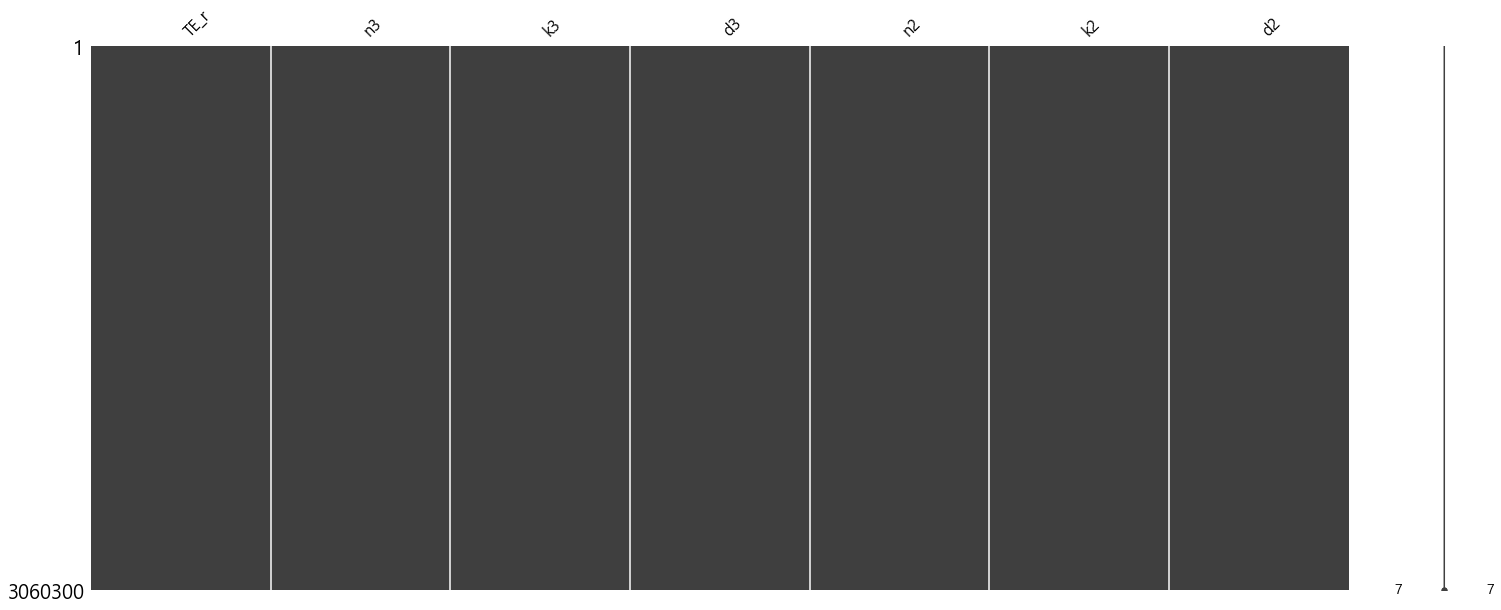

In [6]:
import missingno as msno

msno.matrix(input_data)

#라벨링 설정및 불필요 변수 제거

In [7]:
X_data = input_data.copy()

데이터 경량화(선택)

In [ ]:
# 전체적인 데이터량을 줄여버리는데 그중에 라벨링의 값이 40이 넘는 부분을 버린다.
#X_data = X_data[X_data.label < 40]

In [8]:
y = X_data['TE_r']

In [9]:
X_data.drop('TE_r', axis=1, inplace=True)

In [10]:
X_data.head()

,n3,k3,d3,n2,k2,d2
0,1.69,0.01,48.5,1.85,0.01,48.500
1,1.69,0.01,48.5,1.85,0.01,48.505
2,1.69,0.01,48.5,1.85,0.01,48.510
3,1.69,0.01,48.5,1.85,0.01,48.515
4,1.69,0.01,48.5,1.85,0.01,48.520


# Labeling 분포 확인

In [11]:
y.value_counts()

65.9964    134
64.5936    131
65.9650    130
64.7321    129
64.6034    129
          ... 
62.7464      1
68.0780      1
61.5923      1
61.6425      1
61.6318      1
Name: TE_r, Length: 71818, dtype: int64

<AxesSubplot:xlabel='TE_r', ylabel='Count'>

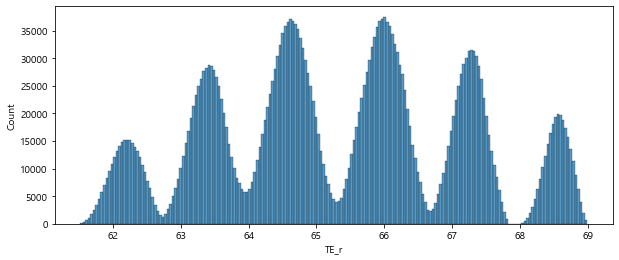

In [12]:
_, ax = plt.subplots(figsize=(10,4))
sns.histplot(data = y)

y.value_counts().sort_index()# XGBClassfier 모델

# Train Test dataset 분리

In [13]:
from sklearn.model_selection import train_test_split

X_rest, X_test, y_rest, y_test = train_test_split(X_data, y, random_state=1234)
X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, random_state=1234)

In [ ]:
'''
y에 대해서 원핫 인코딩을 해주어야한다(수치형이라서 불필요)
혹은 0~1값으면 맞춰주어야 예측에서 작동할듯?
'''

In [14]:
# subsample 0.8이랑 0.6 차이 확인해보기
import xgboost as xgb

bst = xgb.XGBRegressor(n_estimators=100, 
                       #objective='reg:',
                       learning_rate=0.2,
                       max_depth=9, 
                       subsample=0.6,
                       random_state=1234)

bst
bst.get_xgb_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_delta_step': None,
 'max_depth': 9,
 'min_child_weight': None,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 1234,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.6,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [15]:
evals = [(X_valid,y_valid)]
bst.fit(X_train, y_train, 
        early_stopping_rounds=10, 
        eval_metric = ["rmse"], 
        eval_set=evals, 
        verbose=1
)

[0]	validation_0-rmse:51.87427
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:41.49979
[2]	validation_0-rmse:33.20018
[3]	validation_0-rmse:26.56049
[4]	validation_0-rmse:21.24867
[5]	validation_0-rmse:16.99927
[6]	validation_0-rmse:13.59974
[7]	validation_0-rmse:10.88011
[8]	validation_0-rmse:8.70440
[9]	validation_0-rmse:6.96385
[10]	validation_0-rmse:5.57138
[11]	validation_0-rmse:4.45737
[12]	validation_0-rmse:3.56617
[13]	validation_0-rmse:2.85320
[14]	validation_0-rmse:2.28280
[15]	validation_0-rmse:1.82646
[16]	validation_0-rmse:1.46137
[17]	validation_0-rmse:1.16928
[18]	validation_0-rmse:0.93558
[19]	validation_0-rmse:0.74863
[20]	validation_0-rmse:0.59904
[21]	validation_0-rmse:0.47937
[22]	validation_0-rmse:0.38362
[23]	validation_0-rmse:0.30703
[24]	validation_0-rmse:0.24576
[25]	validation_0-rmse:0.19676
[26]	validation_0-rmse:0.15756
[27]	validation_0-rmse:0.12623
[28]	validation_0-rmse:0.10118
[29]	validation_0-rmse:0.08116
[30]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
bst.feature_importances_

array([2.7243616e-03, 6.9873834e-01, 6.5257493e-04, 1.6650485e-03,
       2.9585135e-01, 3.6828208e-04], dtype=float32)

# 모델 검증 및 시각화

In [36]:
from sklearn.metrics import accuracy_score

y_pred = bst.predict(X_test)
print(y_pred)

#print('정확도 :', accuracy_score(y_test, y_pred.round()))

[62.1963  67.32852 62.31784 ... 65.44993 68.55011 67.40049]


모델 오류 참고자료

https://github.com/dmlc/xgboost/issues/2073

https://github.com/dmlc/xgboost/issues/3828

In [ ]:
# 방금시험했던 모델에서는 num_trees가 0~1799개 까지 있었다
xgb.to_graphviz(bst, num_trees=1)

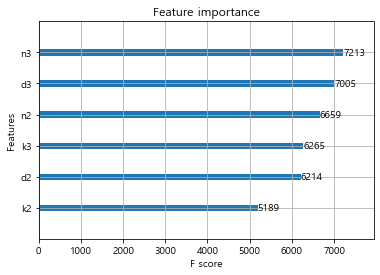

In [18]:
# importance_type 얻을 수 있나싶네요
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [10,8]

# 모델 튜닝

GridSearch 방법

In [ ]:
from sklearn.model_selection import GridSearchCV

bst_param_grid = {
    'learning_rate' : [0.2, 0.3, 0.4],
    'max_depth' : [2, 3, 4],
}

bst_grid = GridSearchCV(bst, param_grid= bst_param_grid, scoring='accuracy', n_jobs=-1, verbose=1)
bst_grid.fit(X_train, y_train)

In [ ]:
bst_grid_df = pd.DataFrame(bst_grid.cv_results_)
bst_grid_df

# 모델 저장

제대로 저장이 안되는 느낌
colab 환경이라 그런가?

In [26]:
bst.save_model('test.json')

# 모델 로드

In [29]:
from pathlib import Path

load_data= Path('../notebooks')

In [31]:
reg = xgb.XGBRegressor(random_state=1234)


reg.load_model(load_data/'test.json')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1234,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='auto', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

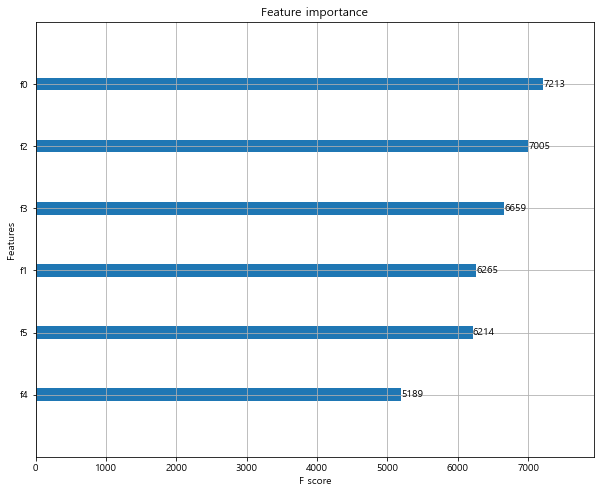

In [32]:
xgb.plot_importance(reg)